If needed, install graphviz above

In [1]:
# for path in sys.path:
#   print(path)

import sys
gems_tco_path = "/Users/joonwonlee/GEMS_TCO/"
sys.path.append(gems_tco_path)

import logging
import argparse # Argument parsing
import math
from collections import defaultdict
import concurrent
from concurrent.futures import ThreadPoolExecutor  # Importing specific executor for clarity
import time

# Data manipulation and analysis
import pandas as pd
import numpy as np

# Nearest neighbor search
import sklearn
from sklearn.neighbors import BallTree

# Special functions and optimizations
from scipy.special import gamma, kv  # Bessel function and gamma function
from scipy.stats import multivariate_normal  # Simulation
from scipy.optimize import minimize
from scipy.spatial.distance import cdist  # For space and time distance
from scipy.spatial import distance  # Find closest spatial point
from scipy.optimize import differential_evolution

# Plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Type hints
from typing import Callable, Union, Tuple

# Add your custom path
# sys.path.append("/cache/home/jl2815/tco")

# Custom imports

from GEMS_TCO import orbitmap 
from GEMS_TCO import kernels 
from GEMS_TCO import evaluate

import pickle
import torch
import torch.optim as optim
import copy                    # clone tensor


load data

In [2]:
lat_lon_resolution = [10,10]
mm_cond_number = 10
params= [20, 8.25, 5.25, 0.2, 0.5, 5]

# Load the one dictionary to set spaital coordinates
# filepath = "C:/Users/joonw/TCO/GEMS_data/data_2023/sparse_cen_map23_01.pkl"
filepath = "/Users/joonwonlee/Documents/GEMS_DATA/pickle_2023/coarse_cen_map23_01.pkl"
with open(filepath, 'rb') as pickle_file:
    coarse_dict_24_1 = pickle.load(pickle_file)

sample_df = coarse_dict_24_1['y23m01day01_hm02:12']

sample_key = coarse_dict_24_1.get('y23m01day01_hm02:12')
if sample_key is None:
    print("Key 'y23m01day01_hm02:12' not found in the dictionary.")

# { (20,20):(5,1), (5,5):(20,40) }
rho_lat = lat_lon_resolution[0]          
rho_lon = lat_lon_resolution[1]
lat_n = sample_df['Latitude'].unique()[::rho_lat]
lon_n = sample_df['Longitude'].unique()[::rho_lon]

lat_number = len(lat_n)
lon_number = len(lon_n)

# Set spatial coordinates for each dataset
coarse_dicts = {}

years = ['2024']
for year in years:
    for month in range(7, 8):  # Iterate over all months
        # filepath = f"C:/Users/joonw/TCO/GEMS_data/data_{year}/sparse_cen_map{year[2:]}_{month:02d}.pkl"
        filepath = f"/Users/joonwonlee/Documents/GEMS_DATA/pickle_{year}/coarse_cen_map{year[2:]}_{month:02d}.pkl"
        with open(filepath, 'rb') as pickle_file:
            loaded_map = pickle.load(pickle_file)
            for key in loaded_map:
                tmp_df = loaded_map[key]
                coarse_filter = (tmp_df['Latitude'].isin(lat_n)) & (tmp_df['Longitude'].isin(lon_n))
                coarse_dicts[f"{year}_{month:02d}_{key}"] = tmp_df[coarse_filter].reset_index(drop=True)


key_idx = sorted(coarse_dicts)
if not key_idx:
    raise ValueError("coarse_dicts is empty")

# extract first hour data because all data shares the same spatial grid
data_for_coord = coarse_dicts[key_idx[0]]
x1 = data_for_coord['Longitude'].values
y1 = data_for_coord['Latitude'].values 
coords1 = np.stack((x1, y1), axis=-1)

instance = orbitmap.MakeOrbitdata(data_for_coord, lat_s=5, lat_e=10, lon_s=110, lon_e=120)
s_dist = cdist(coords1, coords1, 'euclidean')
ord_mm, _ = instance.maxmin_naive(s_dist, 0)

data_for_coord = data_for_coord.iloc[ord_mm].reset_index(drop=True)
coords1_reordered = np.stack((data_for_coord['Longitude'].values, data_for_coord['Latitude'].values), axis=-1)
nns_map = instance.find_nns_naive(locs=coords1_reordered, dist_fun='euclidean', max_nn=mm_cond_number)


idx_for_datamap= [8,16]
analysis_data_map = {}
for i in range(idx_for_datamap[0],idx_for_datamap[1]):
    tmp = coarse_dicts[key_idx[i]].copy()
    tmp['Hours_elapsed'] = np.round(tmp['Hours_elapsed']-477700)

    tmp = tmp.iloc[ord_mm, :4].to_numpy()
    tmp = torch.from_numpy(tmp).float()  # Convert NumPy to Tensor
    # tmp = tmp.clone().detach().requires_grad_(True)  # Enable gradients
    
    analysis_data_map[key_idx[i]] = tmp

aggregated_data = pd.DataFrame()
for i in range(idx_for_datamap[0],idx_for_datamap[1]):
    tmp = coarse_dicts[key_idx[i]].copy()
    tmp['Hours_elapsed'] = np.round(tmp['Hours_elapsed']-477700)
    tmp = tmp.iloc[ord_mm].reset_index(drop=True)  
    aggregated_data = pd.concat((aggregated_data, tmp), axis=0)

aggregated_data = aggregated_data.iloc[:, :4].to_numpy()

aggregated_data = torch.from_numpy(aggregated_data).float()  # Convert NumPy to Tensor
# aggregated_np = aggregated_np.clone().detach().requires_grad_(True)  # Enable gradients


# instance = kernels.likelihood_function(smooth=0.5, input_map=analysis_data_map, nns_map=nns_map, mm_cond_number=mm_cond_number)


# Condition number

In [3]:
# Define your initial parameters
params = [21.8, 1.09, 1.17, 0.2, .2, 0.5, 1]
params = torch.tensor(params, requires_grad=True)

torch_smooth = torch.tensor(0.5, dtype=torch.float32)

instance = kernels.likelihood_function(smooth=torch_smooth , input_map=analysis_data_map,aggregated_data=aggregated_data, nns_map=nns_map, mm_cond_number=mm_cond_number)

out0 = instance.full_likelihood(params, aggregated_data[:,:4],aggregated_data[:,2], instance.matern_cov_anisotropy_v05)
print(out0)

out0 = instance.vecchia_like_local_computer(params, instance.matern_cov_anisotropy_v05)
print(out0)


tensor(2381.0950, grad_fn=<MulBackward0>)
tensor(2473.5378, grad_fn=<AddBackward0>)


In [ ]:
def matern_cov_yx( params: torch.Tensor, y: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
    sigmasq, range_, range_lon, advec, beta, nugget = params
    if y is None or x is None:
        raise ValueError("Both y and x_df must be provided.")

    x1 = x[:, 0]
    y1 = x[:, 1]
    t1 = x[:, 3]

    x2 = y[:, 0]
    y2 = y[:, 1]
    t2 = y[:, 3]

    spat_coord1 = torch.stack((x1 - advec * t1, y1 - advec * t1), dim=-1)
    spat_coord2 = torch.stack((x2 - advec * t2, y2 - advec * t2), dim=-1)

    coords1 = torch.cat((spat_coord1, (beta * t1).reshape(-1, 1)), dim=1)
    coords2 = torch.cat((spat_coord2, (beta * t2).reshape(-1, 1)), dim=1)

  
    def custom_distance_matrix(U, V):
        diff = U[:, :2].unsqueeze(1) - V[:, :2].unsqueeze(0)
        spatial_diff = torch.norm(diff, dim=2)
        temporal_diff = torch.abs(U[:, 2].unsqueeze(1) - V[:, 2].unsqueeze(0))
        return torch.sqrt(spatial_diff**2 + temporal_diff**2)

    distance = custom_distance_matrix(coords1, coords2)
    out = torch.zeros_like(distance)

    non_zero_indices = distance != 0
    if torch.any(non_zero_indices):
        out[non_zero_indices] = sigmasq * torch.exp(-distance[non_zero_indices]/range_)
    out[~non_zero_indices] = sigmasq

    # Add a small jitter term to the diagonal for numerical stability
    out += torch.eye(out.shape[0]) * nugget
    return out

# to track gradient, torch sqrt in distance is moved 
def matern_cov_yx2( params: torch.Tensor, y: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
    sigmasq, range_, range_lon, advec, beta, nugget = params
    if y is None or x is None:
        raise ValueError("Both y and x_df must be provided.")

    x1 = x[:, 0]
    y1 = x[:, 1]
    t1 = x[:, 3]

    x2 = y[:, 0]
    y2 = y[:, 1]
    t2 = y[:, 3]

    spat_coord1 = torch.stack((x1 - advec * t1, y1 - advec * t1), dim=-1)
    spat_coord2 = torch.stack((x2 - advec * t2, y2 - advec * t2), dim=-1)

    coords1 = torch.cat((spat_coord1, (beta * t1).reshape(-1, 1)), dim=1)
    coords2 = torch.cat((spat_coord2, (beta * t2).reshape(-1, 1)), dim=1)

    U= coords1
    V = coords2 
 
    diff = U[:, :2].unsqueeze(1) - V[:, :2].unsqueeze(0)
    spatial_diff = torch.norm(diff, dim=2)
    temporal_diff = torch.abs(U[:, 2].unsqueeze(1) - V[:, 2].unsqueeze(0))
    distance = (spatial_diff**2 + temporal_diff**2)

    out = torch.zeros_like(distance)

    non_zero_indices = distance != 0
    if torch.any(non_zero_indices):
        out[non_zero_indices] = sigmasq * torch.exp(- torch.sqrt(distance[non_zero_indices])/range_)
    out[~non_zero_indices] = sigmasq

    # Add a small jitter term to the diagonal for numerical stability
    out += torch.eye(out.shape[0]) * nugget

    return out


def full_likelihood( params: torch.Tensor, input_np: torch.Tensor, y: torch.Tensor, covariance_function) -> torch.Tensor:
    input_arr = input_np[:, :4]
    y_arr = y

    # Compute the covariance matrix
    cov_matrix = covariance_function(params=params, y=input_arr, x=input_arr)
    
    # Compute the log determinant of the covariance matrix
    sign, log_det = torch.slogdet(cov_matrix)
    # if sign <= 0:
    #     raise ValueError("Covariance matrix is not positive definite")
    
    # Extract locations
    locs = input_arr[:, :2]

    # Compute beta
    tmp1 = torch.matmul(locs.T, torch.linalg.solve(cov_matrix, locs))
    tmp2 = torch.matmul(locs.T, torch.linalg.solve(cov_matrix, y_arr))
    beta = torch.linalg.solve(tmp1, tmp2)

    # Compute the mean
    mu = torch.matmul(locs, beta)
    y_mu = y_arr - mu

    # Compute the quadratic form
    quad_form = torch.matmul(y_mu, torch.linalg.solve(cov_matrix, y_mu))

    # Compute the negative log likelihood
    neg_log_lik = 0.5 * (log_det + quad_form)

    return log_det, quad_form, neg_log_lik
params = [20, 8.25, 5.25, 0.2, 0.5, 5]
params = torch.tensor(params, requires_grad=True)



def matern_partial_sigma( params: torch.Tensor, y: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
    sigmasq, range_, range_lon, advec, beta, nugget = params
    if y is None or x is None:
        raise ValueError("Both y and x_df must be provided.")

    x1 = x[:, 0]
    y1 = x[:, 1]
    t1 = x[:, 3]

    x2 = y[:, 0]
    y2 = y[:, 1]
    t2 = y[:, 3]

    spat_coord1 = torch.stack((x1 - advec * t1, y1 - advec * t1), dim=-1)
    spat_coord2 = torch.stack((x2 - advec * t2, y2 - advec * t2), dim=-1)

    coords1 = torch.cat((spat_coord1, (beta * t1).reshape(-1, 1)), dim=1)
    coords2 = torch.cat((spat_coord2, (beta * t2).reshape(-1, 1)), dim=1)

    def custom_distance_matrix(U, V):
        diff = U[:, :2].unsqueeze(1) - V[:, :2].unsqueeze(0)
        spatial_diff = torch.norm(diff, dim=2)
        temporal_diff = torch.abs(U[:, 2].unsqueeze(1) - V[:, 2].unsqueeze(0))
        return torch.sqrt(spatial_diff**2 + temporal_diff**2)

    distance = custom_distance_matrix(coords1, coords2)
    out = torch.zeros_like(distance)

    non_zero_indices = distance != 0
    if torch.any(non_zero_indices):
        out[non_zero_indices] = torch.exp(-distance[non_zero_indices]/range_)
    out[~non_zero_indices] = 1


    return out

def matern_partial_range( params: torch.Tensor, y: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
    sigmasq, range_, range_lon, advec, beta, nugget = params
    if y is None or x is None:
        raise ValueError("Both y and x_df must be provided.")

    x1 = x[:, 0]
    y1 = x[:, 1]
    t1 = x[:, 3]

    x2 = y[:, 0]
    y2 = y[:, 1]
    t2 = y[:, 3]
 
    spat_coord1 = torch.stack((x1 - advec * t1, y1 - advec * t1), dim=-1)
    spat_coord2 = torch.stack((x2 - advec * t2, y2 - advec * t2), dim=-1)

    coords1 = torch.cat((spat_coord1, (beta * t1).reshape(-1, 1)), dim=1)
    coords2 = torch.cat((spat_coord2, (beta * t2).reshape(-1, 1)), dim=1)

    def custom_distance_matrix(U, V):
        diff = U[:, :2].unsqueeze(1) - V[:, :2].unsqueeze(0)
        spatial_diff = torch.norm(diff, dim=2)
        temporal_diff = torch.abs(U[:, 2].unsqueeze(1) - V[:, 2].unsqueeze(0))
        return torch.sqrt(spatial_diff**2 + temporal_diff**2)

    distance = custom_distance_matrix(coords1, coords2)
    out = torch.zeros_like(distance)

    non_zero_indices = distance != 0
    if torch.any(non_zero_indices):
        out[non_zero_indices] = sigmasq * torch.exp(-distance[non_zero_indices] / range_)
    out[~non_zero_indices] = sigmasq

    # Compute the derivative with respect to the range parameter
    derivative = torch.zeros_like(distance)
    if torch.any(non_zero_indices):
        derivative[non_zero_indices] = out[non_zero_indices] * distance[non_zero_indices] / range_**2

    # Ensure the derivative on the diagonal is zero
    derivative.fill_diagonal_(0)
    
    return derivative

def matern_partial_nugget( params: torch.Tensor, y: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
    sigmasq, range_, range_lon, advec, beta, nugget = params
    if y is None or x is None:
        raise ValueError("Both y and x_df must be provided.")

    x1 = x[:, 0]
    y1 = x[:, 1]
    t1 = x[:, 3]

    x2 = y[:, 0]
    y2 = y[:, 1]
    t2 = y[:, 3]

    spat_coord1 = torch.stack((x1 - advec * t1, y1 - advec * t1), dim=-1)
    spat_coord2 = torch.stack((x2 - advec * t2, y2 - advec * t2), dim=-1)

    coords1 = torch.cat((spat_coord1, (beta * t1).reshape(-1, 1)), dim=1)
    coords2 = torch.cat((spat_coord2, (beta * t2).reshape(-1, 1)), dim=1)

    def custom_distance_matrix(U, V):
        diff = U[:, :2].unsqueeze(1) - V[:, :2].unsqueeze(0)
        spatial_diff = torch.norm(diff, dim=2)
        temporal_diff = torch.abs(U[:, 2].unsqueeze(1) - V[:, 2].unsqueeze(0))
        return torch.sqrt(spatial_diff**2 + temporal_diff**2)

    distance = custom_distance_matrix(coords1, coords2)
    out = torch.zeros_like(distance)

    
    non_zero_indices = distance != 0
    if torch.any(non_zero_indices):
        out[non_zero_indices] = 0
    out[~non_zero_indices] = 1

    return out

def matern_partial_beta( params: torch.Tensor, y: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
    sigmasq, range_, range_lon, advec, beta, nugget = params
    if y is None or x is None:
        raise ValueError("Both y and x_df must be provided.")

    x1 = x[:, 0]
    y1 = x[:, 1]
    t1 = x[:, 3]

    x2 = y[:, 0]
    y2 = y[:, 1]
    t2 = y[:, 3]

    spat_coord1 = torch.stack((x1 - advec * t1, y1 - advec * t1), dim=-1)
    spat_coord2 = torch.stack((x2 - advec * t2, y2 - advec * t2), dim=-1)

    coords1 = torch.cat((spat_coord1, (beta * t1).reshape(-1, 1)), dim=1)
    coords2 = torch.cat((spat_coord2, (beta * t2).reshape(-1, 1)), dim=1)

    def custom_distance_matrix(U, V):
        diff = U[:, :2].unsqueeze(1) - V[:, :2].unsqueeze(0)
        spatial_diff = torch.norm(diff, dim=2)
        temporal_diff = torch.abs(U[:, 2].unsqueeze(1) - V[:, 2].unsqueeze(0))
        return torch.sqrt(spatial_diff**2 + temporal_diff**2)


    distance = custom_distance_matrix(coords1, coords2)
    out = torch.zeros_like(distance)

    non_zero_indices = distance != 0
    if torch.any(non_zero_indices):
        tmp1 = sigmasq * torch.exp(-distance[non_zero_indices]/range_)*(-1/range_)
        
        tmp2 = (beta/distance[non_zero_indices])

                # Adjust t2 - t1 for non-zero indices
        t1_non_zero = t1.unsqueeze(1).expand_as(distance)[non_zero_indices]
        t2_non_zero = t2.unsqueeze(0).expand_as(distance)[non_zero_indices]

        out[non_zero_indices] = tmp1 * tmp2 *(t2_non_zero - t1_non_zero)**2

    out[~non_zero_indices] = 0

    return out

def matern_partial_advec( params: torch.Tensor, y: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
    sigmasq, range_, range_lon, advec, beta, nugget = params
    if y is None or x is None:
        raise ValueError("Both y and x_df must be provided.")

    x1 = x[:, 0]
    y1 = x[:, 1]
    t1 = x[:, 3]

    x2 = y[:, 0]
    y2 = y[:, 1]
    t2 = y[:, 3]

    spat_coord1 = torch.stack((x1 - advec * t1, y1 - advec * t1), dim=-1)
    spat_coord2 = torch.stack((x2 - advec * t2, y2 - advec * t2), dim=-1)

    coords1 = torch.cat((spat_coord1, (beta * t1).reshape(-1, 1)), dim=1)
    coords2 = torch.cat((spat_coord2, (beta * t2).reshape(-1, 1)), dim=1)

    def custom_distance_matrix(U, V):
        diff = U[:, :2].unsqueeze(1) - V[:, :2].unsqueeze(0)
        spatial_diff = torch.norm(diff, dim=2)
        temporal_diff = torch.abs(U[:, 2].unsqueeze(1) - V[:, 2].unsqueeze(0))
        return torch.sqrt(spatial_diff**2 + temporal_diff**2)


    distance = custom_distance_matrix(coords1, coords2)
    out = torch.zeros_like(distance)

    non_zero_indices = distance != 0
    if torch.any(non_zero_indices):
        tmp1 = sigmasq * torch.exp(-distance[non_zero_indices]/range_)*(-1/range_)

        # Adjust t2 - t1 for non-zero indices
        t1_non_zero = t1.unsqueeze(1).expand_as(distance)[non_zero_indices]
        t2_non_zero = t2.unsqueeze(0).expand_as(distance)[non_zero_indices]
        x1_non_zero = x1.unsqueeze(1).expand_as(distance)[non_zero_indices]
        x2_non_zero = x2.unsqueeze(0).expand_as(distance)[non_zero_indices]
        y1_non_zero = y1.unsqueeze(1).expand_as(distance)[non_zero_indices]
        y2_non_zero = y2.unsqueeze(0).expand_as(distance)[non_zero_indices]

        tmp2 = (t2_non_zero - t1_non_zero )
        tmp3 = tmp2* ( (x1_non_zero-x2_non_zero) - advec*(t1_non_zero - t2_non_zero) +  (y1_non_zero-y2_non_zero) - advec*(t1_non_zero - t2_non_zero) )

        out[non_zero_indices] = tmp1* (1/ distance[non_zero_indices]) * tmp3

    out[~non_zero_indices] = 0
    return out

def full_partial( params: torch.Tensor, input_np: torch.Tensor, y: torch.Tensor, covariance_function, partial_fun) -> torch.Tensor:
    input_arr = input_np[:, :4]
    y_arr = y

    # Compute the covariance matrix
    cov_matrix = covariance_function(params=params, y=input_arr, x=input_arr)
    partial_der = partial_fun(params=params, y=input_arr, x=input_arr)
    
    # Compute the log determinant of the covariance matrix
    # sign, log_det = torch.slogdet(cov_matrix)
    # if sign <= 0:
    #     raise ValueError("Covariance matrix is not positive definite")
    
    # Extract locations
    locs = input_arr[:, :2]

    # Compute beta
    tmp1 = torch.matmul(locs.T, torch.linalg.solve(cov_matrix, locs))
    tmp2 = torch.matmul(locs.T, torch.linalg.solve(cov_matrix, y_arr))
    beta = torch.linalg.solve(tmp1, tmp2)

    # Compute the mean
    mu = torch.matmul(locs, beta)
    y_mu = y_arr - mu

    # Compute the quadratic form
    tmp1 = torch.linalg.solve(cov_matrix, partial_der)
    tmp2 = torch.matmul(y_mu, tmp1)
    tmp3 = torch.linalg.solve(cov_matrix, y_mu)
    quad_form =  -torch.matmul(tmp2,tmp3 )
    log_det = torch.trace(tmp1)
    # Compute the negative log likelihood
    neg_log_lik = 0.5 * (log_det + quad_form)
    
    return log_det, quad_form, neg_log_lik

params = [20, 8.25, 5.25, 0.2, 0.5, 0.5]
params = torch.tensor(params, requires_grad=True)



a,b,c = full_partial(params, aggregated_np[:,:4], aggregated_np[:,2], matern_cov_yx, matern_partial_sigma)
print(f'sigma log_det:{a}')
print(f'sigma quad_form:{b}')
print(f'sigma quad_form:{c}')

a,b,c = full_partial(params, aggregated_np[:,:4], aggregated_np[:,2], matern_cov_yx, matern_partial_range)
print(f'\nrange log_det:{a}')
print(f'range quad_form:{b}')
print(f'range quad_form:{c}')

a,b,c = full_partial(params, aggregated_np[:,:4], aggregated_np[:,2], matern_cov_yx, matern_partial_nugget)
print(f'\nnugget log_det:{a}')
print(f'nugget quad_form:{b}')
print(f'nugget quad_form:{c}')

matern_partial_sigma(params, aggregated_np[:,:4], aggregated_np[:,:4])
a,b,c = full_partial(params, aggregated_np[:,:4], aggregated_np[:,2], matern_cov_yx, matern_partial_beta)
print(f'\nbeta log_det:{a}')
print(f'beta quad_form:{b}')
print(f'beta quad_form:{c}')

matern_partial_sigma(params, aggregated_np[:,:4], aggregated_np[:,:4])
a,b,c = full_partial(params, aggregated_np[:,:4], aggregated_np[:,2], matern_cov_yx, matern_partial_advec)
print(f'\nadvec log_det:{a}')
print(f'advec quad_form:{b}')
print(f'advec quad_form:{c}')

sigma log_det:242.9289093017578
sigma quad_form:-961.7320556640625
sigma quad_form:-359.4015808105469

range log_det:-587.5875854492188
range quad_form:2323.924560546875
range quad_form:868.16845703125

nugget log_det:10282.84765625
nugget quad_form:-40214.4609375
nugget quad_form:-14965.806640625

beta log_det:1312.11962890625
beta quad_form:-3439.30322265625
beta quad_form:-1063.591796875

advec log_det:74.23946380615234
advec quad_form:4194.55712890625
advec quad_form:2134.398193359375


## Great circle distance vs Euclidean distance 
   
In small area, the difference between great circle distance (gcd) and euclidean distance should be small. However, model can try to account for curvature in small area resulting in overfitting. Haversine formula might cause numerical errors because it involves sin and cos for small distances. Also, incompatability between gcd for space and euclidean for time might be an issue.

Based on my experiment, likelihood was way higher when using euclidean distance for space. 


def custom_distance_matrix(self, U, V):
    # Efficient distance computation with broadcasting
    spatial_diff = torch.norm(U[:, :2].unsqueeze(1) - V[:, :2].unsqueeze(0), dim=2)

    temporal_diff = torch.abs(U[:, 2].unsqueeze(1) - V[:, 2].unsqueeze(0))
    distance = (spatial_diff**2 + temporal_diff**2)  # move torch.sqrt to covariance function to track gradients of beta and avec
    return distance

#################################################################################
#################################################################################

def great_circle_distance(self, lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(torch.deg2rad, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = torch.sin(dlat / 2)**2 + torch.cos(lat1) * torch.cos(lat2) * torch.sin(dlon / 2)**2
    c = 2 * torch.atan2(torch.sqrt(a), torch.sqrt(1 - a))
    
    # Radius of Earth in kilometers (mean radius)
    R = 6371.0
    return R * c
def custom_distance_matrix(self, U, V):
    # Efficient distance computation with broadcasting
    lat1, lon1 = U[:, 0].unsqueeze(1), U[:, 1].unsqueeze(1)
    lat2, lon2 = V[:, 0].unsqueeze(0), V[:, 1].unsqueeze(0)
    
    spatial_diff = self.great_circle_distance(lat1, lon1, lat2, lon2)
    temporal_diff = torch.abs(U[:, 2].unsqueeze(1) - V[:, 2].unsqueeze(0))
    distance = (spatial_diff**2 + temporal_diff**2)  # move torch.sqrt to covariance function to track gradients of beta and avec
    return distance

In [29]:

params = [24.42, 1.92, 1.92, -0.045, 0.237, 3.34]
params = torch.tensor(params, requires_grad=True)

params = [23.59, 3.83, 3.83, 0.036, 0.277, 2.83]
params = torch.tensor(params, requires_grad=True)

# Choose your optimizer
params = [20, 8.25, 5.25, 0.2, 0.2, 0.2]
params = torch.tensor(params, requires_grad=True)

# optimizer = optim.Adam([params], lr=0.01)  # For Adam
optimizer = optim.Adam([params],lr=0.01, betas=(0.9, 0.8), eps=1e-8)


# Example function to compute out1
def compute_out1(params):
    # Compute the output using your function
    logdet, quad, nll = full_likelihood(params, aggregated_np[:,:4], aggregated_np[:,2], matern_cov_yx2)
    return nll

# Training loop
prev_loss = float('inf')
tol = 1e-4  # Convergence tolerance
for epoch in range(5):  # Number of epochs
    optimizer.zero_grad()  # Zero the gradients 
    
    loss = compute_out1(params)
    loss.backward()  # Backpropagate the loss
    
    # Print gradients and parameters every 10th epoch
    # if epoch % 10 == 0:
    #    print(f'Epoch {epoch+1}, Gradients: {params.grad.numpy()}\n Loss: {loss.item()}, Parameters: {params.detach().numpy()}')
    
    print(f'Epoch {epoch+1}, Gradients: {params.grad.numpy()}\n Loss: {loss.item()}, Parameters: {params.detach().numpy()}')
    
    optimizer.step()  # Update the parameters
    
    # Check for convergence
    if abs(prev_loss - loss.item()) < tol:
        print(f"Converged at epoch {epoch}")
        break
    
    prev_loss = loss.item()

print('Training complete.') 


Epoch 1, Gradients: [  -933.03125   2258.1394       0.       12576.844   -53374.29
 -52156.84   ]
 Loss: 32311.650390625, Parameters: [20.    8.25  5.25  0.2   0.2   0.2 ]
Epoch 2, Gradients: [  -884.3828   2144.0613      0.      12525.543  -45290.445  -48153.176 ]
 Loss: 31161.375, Parameters: [20.01        8.24        5.25        0.19        0.21000001  0.21000001]
Epoch 3, Gradients: [  -840.08984   2040.1005       0.       12101.752   -38366.492
 -44667.227  ]
 Loss: 30125.9765625, Parameters: [20.020012    8.229988    5.25        0.17999882  0.2200146   0.22001551]
Epoch 4, Gradients: [  -799.5547   1944.9866      0.      11451.225  -32472.53   -41618.234 ]
 Loss: 29192.111328125, Parameters: [20.030045    8.219957    5.25        0.16998489  0.23005317  0.2300561 ]
Epoch 5, Gradients: [  -762.375    1857.6241      0.      10681.508  -27462.625  -38936.58  ]
 Loss: 28347.4921875, Parameters: [20.040104    8.2099      5.25        0.1599448   0.2401249   0.24013074]
Training complete

add vecchia

In [30]:
smooth= 0.5
input_map = analysis_data_map

class test:
    def __init__(self, params, covariance_function, nns_map):
        self.smooth = smooth
        self.input_map = input_map
        self.key_list = sorted(input_map)
        self.number_of_timestamps = len(self.key_list)

        sample_df = input_map[self.key_list[0]]

        self.size_per_hour = len(sample_df)
        self.mm_cond_number = mm_cond_number
        nns_map = list(nns_map) # nns_map is ndarray this allows to have sub array of diffrent lengths
        for i in range(len(nns_map)):  
            # Select elements up to mm_cond_number and remove -1
            tmp = np.delete(nns_map[i][:self.mm_cond_number], np.where(nns_map[i][:self.mm_cond_number] == -1))
            if tmp.size>0:
                nns_map[i] = tmp
            else:
                nns_map[i] = []
        self.nns_map = nns_map

    def matern_cov_yx2( self,params: torch.Tensor, y: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        sigmasq, range_, range_lon, advec, beta, nugget = params
        if y is None or x is None:
            raise ValueError("Both y and x_df must be provided.")

        x1 = x[:, 0]
        y1 = x[:, 1]
        t1 = x[:, 3]

        x2 = y[:, 0]
        y2 = y[:, 1]
        t2 = y[:, 3]

        spat_coord1 = torch.stack((x1 - advec * t1, y1 - advec * t1), dim=-1)
        spat_coord2 = torch.stack((x2 - advec * t2, y2 - advec * t2), dim=-1)

        coords1 = torch.cat((spat_coord1, (beta * t1).reshape(-1, 1)), dim=1)
        coords2 = torch.cat((spat_coord2, (beta * t2).reshape(-1, 1)), dim=1)

        U= coords1
        V = coords2 
    
        diff = U[:, :2].unsqueeze(1) - V[:, :2].unsqueeze(0)
        spatial_diff = torch.norm(diff, dim=2)
        temporal_diff = torch.abs(U[:, 2].unsqueeze(1) - V[:, 2].unsqueeze(0))
        distance = (spatial_diff**2 + temporal_diff**2)

        out = torch.zeros_like(distance)

        non_zero_indices = distance != 0
        if torch.any(non_zero_indices):
            out[non_zero_indices] = sigmasq * torch.exp(- torch.sqrt(distance[non_zero_indices])/range_)
        out[~non_zero_indices] = sigmasq

        # Add a small jitter term to the diagonal for numerical stability
        out += torch.eye(out.shape[0]) * nugget

        return out


    def full_likelihood(self, params: torch.Tensor, input_np: torch.Tensor, y: torch.Tensor, covariance_function) -> torch.Tensor:
        input_arr = input_np[:, :4]
        y_arr = y

        # Compute the covariance matrix
        cov_matrix = covariance_function(params=params, y=input_arr, x=input_arr)
        
        # Compute the log determinant of the covariance matrix
        sign, log_det = torch.slogdet(cov_matrix)
        # if sign <= 0:
        #     raise ValueError("Covariance matrix is not positive definite")
        
        # Extract locations
        locs = input_arr[:, :2]

        # Compute beta
        tmp1 = torch.matmul(locs.T, torch.linalg.solve(cov_matrix, locs))
        tmp2 = torch.matmul(locs.T, torch.linalg.solve(cov_matrix, y_arr))
        beta = torch.linalg.solve(tmp1, tmp2)

        # Compute the mean
        mu = torch.matmul(locs, beta)
        y_mu = y_arr - mu

        # Compute the quadratic form
        quad_form = torch.matmul(y_mu, torch.linalg.solve(cov_matrix, y_mu))

        # Compute the negative log likelihood
        neg_log_lik = 0.5 * (log_det + quad_form)
        # log_det, quad_form,
        return  neg_log_lik


    def vecchia_like_local(self, params: torch.Tensor, covariance_function) -> torch.Tensor:
        self.cov_map = defaultdict(list)
        neg_log_lik = 0.0
        
        for time_idx in range(self.number_of_timestamps):
            current_np = self.input_map[self.key_list[time_idx]]

            # Use below when working on local computer to avoid singular matrix
            cur_heads = current_np[:21, :]
            neg_log_lik += self.full_likelihood(params, cur_heads, cur_heads[:, 2], covariance_function)

            for index in range(21, self.size_per_hour):
                current_row = current_np[index].reshape(1, -1)
                current_y = current_row[0, 2]

                # Construct conditioning set
                mm_neighbors = self.nns_map[index]
                past = list(mm_neighbors)
                data_list = []

                if past:
                    data_list.append(current_np[past])

                if time_idx > 1:
                    cov_matrix = self.cov_map[index]['cov_matrix']
                    tmp_for_beta = self.cov_map[index]['tmp_for_beta']
                    cov_xx_inv = self.cov_map[index]['cov_xx_inv']
                    L_inv = self.cov_map[index]['L_inv']
                    cov_ygivenx = self.cov_map[index]['cov_ygivenx']
                    cond_mean_tmp = self.cov_map[index]['cond_mean_tmp']
                    log_det = self.cov_map[index]['log_det']
                    locs = self.cov_map[index]['locs']
                    
                    last_hour_np = self.input_map[self.key_list[time_idx - 1]]
                    past_conditioning_data = last_hour_np[past + [index], :]
                    data_list.append(past_conditioning_data)

                    if data_list:
                        conditioning_data = torch.vstack(data_list)
                    else:
                        conditioning_data = torch.empty((0, current_row.shape[1]), dtype=torch.float32)

                    np_arr = torch.vstack((current_row, conditioning_data))
                    y_and_neighbors = np_arr[:, 2]

                    cov_yx = cov_matrix[0, 1:]

                    tmp2 = torch.matmul(torch.matmul(L_inv, locs).T, torch.matmul(L_inv, y_and_neighbors))
                    beta = torch.linalg.solve(tmp_for_beta, tmp2)

                    mu = torch.matmul(locs, beta)
                    mu_current = mu[0]
                    mu_neighbors = mu[1:]
                    
                    # Mean and variance of y|x
                    cond_mean = mu_current + torch.matmul(cond_mean_tmp, (y_and_neighbors[1:] - mu_neighbors))
                    alpha = current_y - cond_mean
                    quad_form = alpha**2 * (1 / cov_ygivenx)
                    neg_log_lik += 0.5 * (log_det + quad_form)

                    continue

                if time_idx > 0:
                    last_hour_np = self.input_map[self.key_list[time_idx - 1]]
                    past_conditioning_data = last_hour_np[past + [index], :]
                    data_list.append(past_conditioning_data)

                if data_list:
                    conditioning_data = torch.vstack(data_list)
                else:
                    conditioning_data = torch.empty((0, current_row.shape[1]), dtype=torch.float32)

                np_arr = torch.vstack((current_row, conditioning_data))
                y_and_neighbors = np_arr[:, 2]
                locs = np_arr[:, :2]

                cov_matrix = covariance_function(params=params, y=np_arr, x=np_arr)
               

                # print(f'Condition number: {torch.linalg.cond(cov_matrix)}')
                L = torch.linalg.cholesky(cov_matrix)
                L11 = L[:1, :1]
                L12 = torch.zeros(L[:1, 1:].shape)
                L21 = L[1:, :1]
                L22 = L[1:, 1:]
                L11_inv = torch.linalg.inv(L11)
                L22_inv = torch.linalg.inv(L22)

                L_inv = torch.block_diag(L11_inv, L22_inv)
                L_inv[1:, :1] = -torch.matmul(L22_inv, L21) @ L11_inv

                cov_yx = cov_matrix[0, 1:]

                tmp1 = torch.matmul(L_inv, locs)
                tmp2 = torch.matmul(torch.matmul(L_inv, locs).T, torch.matmul(L_inv, y_and_neighbors))
                tmp_for_beta = torch.matmul(tmp1.T, tmp1)
                beta = torch.linalg.solve(tmp_for_beta, tmp2)

                mu = torch.matmul(locs, beta)
                mu_current = mu[0]
                mu_neighbors = mu[1:]

                # Mean and variance of y|x
                sigma = cov_matrix[0, 0]
                cov_xx = cov_matrix[1:, 1:]
                cov_xx_inv = torch.linalg.inv(cov_xx)

                cov_ygivenx = sigma - torch.matmul(cov_yx, torch.matmul(cov_xx_inv, cov_yx))
                cond_mean_tmp = torch.matmul(cov_yx, cov_xx_inv)
                cond_mean = mu_current + torch.matmul(cond_mean_tmp, (y_and_neighbors[1:] - mu_neighbors))
                
                alpha = current_y - cond_mean
                quad_form = alpha**2 * (1 / cov_ygivenx)
                log_det = torch.log(cov_ygivenx)
                neg_log_lik += 0.5 * (log_det + quad_form)

                if time_idx == 1:
                    self.cov_map[index] = {
                        'tmp_for_beta': tmp_for_beta,
                        'cov_xx_inv': cov_xx_inv,
                        'cov_matrix': cov_matrix,
                        'L_inv': L_inv,
                        'cov_ygivenx': cov_ygivenx,
                        'cond_mean_tmp': cond_mean_tmp,
                        'log_det': log_det,
                        'locs': locs
                    }

        return neg_log_lik    

In [31]:

# Choose your optimizer
params = [24.56, 2.8, -0.0138, -0.0138, 0.301, 2.12]
params = [20, 8.25, 5.25, 0.2, 0.2, 0.2]
params = torch.tensor(params, requires_grad=True)  # Move params to GPU

instance = test(params, matern_cov_yx2, nns_map)

# optimizer = optim.Adam([params], lr=0.01)  # For Adam
optimizer = optim.Adam([params], lr=0.01, betas=(0.9, 0.8), eps=1e-8)

# Example function to compute out1
def compute_out1(params):
    # Compute the output using your function
    # nll = instance.full_likelihood(params, instance.matern_advec_beta_cov )
    nll = instance.vecchia_like_local(params, instance.matern_cov_yx2)
    return nll

# Training loop
prev_loss = float('inf')
tol = 1e-4  # Convergence tolerance
for epoch in range(5):  # Number of epochs
    optimizer.zero_grad()  # Zero the gradients 
    
    loss = compute_out1(params)
    loss.backward()  # Backpropagate the loss
    
    # Print gradients and parameters every epoch
    print(f'Epoch {epoch+1}, Gradients: {params.grad.cpu().numpy()}\n Loss: {loss.item()}, Parameters: {params.detach().cpu().numpy()}')
    
    optimizer.step()  # Update the parameters
    
    # Check for convergence
    if abs(prev_loss - loss.item()) < tol:
        print(f"Converged at epoch {epoch}")
        break
    
    prev_loss = loss.item()

print('Training complete.')



Epoch 1, Gradients: [  -832.96356   2008.8931       0.        2616.815   -21329.596
 -45802.062  ]
 Loss: 29469.2421875, Parameters: [20.    8.25  5.25  0.2   0.2   0.2 ]
Epoch 2, Gradients: [  -798.32556   1928.7511       0.        3193.0464  -18382.76
 -43028.195  ]
 Loss: 28769.65625, Parameters: [20.01        8.24        5.25        0.19        0.21000001  0.21000001]
Epoch 3, Gradients: [  -766.0154   1853.9928      0.       3346.1123 -15799.338  -40544.676 ]
 Loss: 28121.486328125, Parameters: [20.02001     8.22999     5.25        0.18010429  0.2200161   0.22001348]
Epoch 4, Gradients: [  -735.80426   1783.925        0.        3241.5635  -13577.053
 -38313.117  ]
 Loss: 27519.9765625, Parameters: [20.030037    8.219964    5.25        0.17023773  0.23005867  0.23004872]
Epoch 5, Gradients: [  -707.50916   1718.3488       0.        3002.666   -11684.366
 -36302.64   ]
 Loss: 26962.177734375, Parameters: [20.040087    8.209916    5.25        0.16035141  0.24013798  0.2401134 ]
Train

## Class using analytical derivatives

In [18]:
class matern_advec_beta:
    def __init__(self, aggregated_np: torch.Tensor, params: torch.Tensor):
        self.aggregated_np = aggregated_np[:,:4]
        self.y = aggregated_np[:,2]
        self.aggregated_locs = aggregated_np[:,:2]
        aggregated_np_clone = copy.deepcopy(aggregated_np)
        self.x1 = aggregated_np[:,0]
  
        self.y1 = aggregated_np[:,1]
        self.t1 = aggregated_np[:,3]

        self.x2 = aggregated_np_clone[:,0]
        self.y2 = aggregated_np_clone[:,1]
        self.t2 = aggregated_np_clone[:,3] 
        self.params = params 

        self.distance, self.non_zero_indices = self.precompute_coords(params)
                # Adjust t2 - t1 for non-zero indices
        self.t1_non_zero = self.t1.unsqueeze(1).expand_as(self.distance)[self.non_zero_indices]
        self.t2_non_zero = self.t2.unsqueeze(0).expand_as(self.distance)[self.non_zero_indices]
        self.x1_non_zero = self.x1.unsqueeze(1).expand_as(self.distance)[self.non_zero_indices]
        self.x2_non_zero = self.x2.unsqueeze(0).expand_as(self.distance)[self.non_zero_indices]
        self.y1_non_zero = self.y1.unsqueeze(1).expand_as(self.distance)[self.non_zero_indices]
        self.y2_non_zero = self.y2.unsqueeze(0).expand_as(self.distance)[self.non_zero_indices]
    
    def custom_distance_matrix(self, U, V):
        # Efficient distance computation with broadcasting
        spatial_diff = torch.norm(U[:, :2].unsqueeze(1) - V[:, :2].unsqueeze(0), dim=2)
        temporal_diff = torch.abs(U[:, 2].unsqueeze(1) - V[:, 2].unsqueeze(0))
        distance = torch.sqrt(spatial_diff**2 + temporal_diff**2)  # Keeping torch.sqrt for proper gradients
        return distance

    def precompute_coords(self, params)-> torch.Tensor:
        igmasq, range_,  advec, beta, nugget = params
        # spat_coord1 = torch.stack((self.x1 , self.y1 - advec * self.t1), dim=-1)
        spat_coord1 = torch.stack((self.x1 - advec * self.t1, self.y1 ), dim=-1)
        spat_coord2 = torch.stack((self.x2 - advec * self.t2, self.y2 ), dim=-1)

        U = torch.cat((spat_coord1, (beta * self.t1).reshape(-1, 1)), dim=1)
        V = torch.cat((spat_coord2, (beta * self.t2).reshape(-1, 1)), dim=1)

        distance = self.custom_distance_matrix(U,V)
        non_zero_indices = distance != 0
        return distance, non_zero_indices

    def matern_advec_beta_cov(self,params) -> torch.Tensor:
        sigmasq, range_,  advec, beta, nugget = params
        
        out = torch.zeros_like(self.distance)

        out[self.non_zero_indices] = sigmasq * torch.exp(- (self.distance[self.non_zero_indices])/range_)
        out[~self.non_zero_indices] = sigmasq

        # Add a small jitter term to the diagonal for numerical stability
        out += torch.eye(out.shape[0]) * nugget

        return out

    def matern_partial_sigma(self, params) -> torch.Tensor:
        sigmasq, range_, advec, beta, nugget = params
        out = torch.zeros_like(self.distance)

        # Cache the non-zero indices distance
        non_zero_distance = self.distance[self.non_zero_indices]

        # Compute the exponential term
        exp_term = torch.exp_(-non_zero_distance / range_)

        # Assign the computed values to the output tensor
        out[self.non_zero_indices] = exp_term
        out[~self.non_zero_indices] = 1

        return out

    def matern_partial_range(self, params: torch.Tensor ) -> torch.Tensor:
        sigmasq, range_,  advec, beta, nugget = params

        out = torch.zeros_like(self.distance)
    
        tmp = sigmasq * torch.exp(-(self.distance[self.non_zero_indices]) / range_) 
        out[self.non_zero_indices] = tmp * (self.distance[self.non_zero_indices])  / range_**2

        return out
    def matern_partial_nugget(self, params: torch.Tensor) -> torch.Tensor:
        sigmasq, range_,  advec, beta, nugget = params

        out = torch.zeros_like(self.distance)

   
        out[self.non_zero_indices] = 0
        out[~self.non_zero_indices] = 1

        return out

    def matern_partial_advec(self, params: torch.Tensor) -> torch.Tensor:
        sigmasq, range_,  advec, beta, nugget = params


        out = torch.zeros_like(self.distance)

        tmp1 = sigmasq * torch.exp(-(self.distance[self.non_zero_indices]) /range_)*(-1/range_)


        tmp2 = (self.t2_non_zero - self.t1_non_zero )
        tmp3 = tmp2* ( (self.x1_non_zero-self.x2_non_zero) - advec*(self.t1_non_zero - self.t2_non_zero) +  (self.y1_non_zero-self.y2_non_zero) - advec*(self.t1_non_zero - self.t2_non_zero) )

        out[self.non_zero_indices] = tmp1* (1/ (self.distance[self.non_zero_indices]) ) * tmp3

        out[~self.non_zero_indices] = 0
        return out
    
    def matern_partial_beta(self, params: torch.Tensor) -> torch.Tensor:
        sigmasq, range_,  advec, beta, nugget = params
    

        out = torch.zeros_like(self.distance)

        tmp1 = sigmasq * torch.exp(-(self.distance[self.non_zero_indices])/range_)*(-1/range_)
        
        tmp2 = (beta/(self.distance[self.non_zero_indices]))


        out[self.non_zero_indices] = tmp1 * tmp2 *(self.t2_non_zero - self.t1_non_zero)**2

        out[~self.non_zero_indices] = 0

        return out
    

    def cov_and_inv(self, params):
        cov_matrix = self.matern_advec_beta_cov( params=params)
        cov_inv = torch.linalg.inv(cov_matrix)
                
        # Compute beta
        tmp1 = torch.matmul(self.aggregated_locs.T, torch.linalg.solve(cov_matrix, self.aggregated_locs))
        tmp2 = torch.matmul(self.aggregated_locs.T, torch.linalg.solve(cov_matrix, self.y))
        beta = torch.linalg.solve(tmp1, tmp2)

        # Compute the mean
        mu = torch.matmul(self.aggregated_locs, beta)
        y_mu = self.y - mu
        tmp3 = torch.matmul(cov_inv, y_mu)
        return cov_matrix, cov_inv, mu, tmp3
    
    def full_partial(self, params: torch.Tensor, partial_der_fun, cov_matrix, cov_inv,mu, tmp3) -> torch.Tensor:
        

        partial_der = partial_der_fun(params)
        
        # Compute the log determinant of the covariance matrix
        # sign, log_det = torch.slogdet(cov_matrix)
        # if sign <= 0:
        #     raise ValueError("Covariance matrix is not positive definite")
        
        y_mu = self.y - mu

        # Compute the quadratic form derivative
        # tmp1 = torch.linalg.solve(cov_matrix, partial_der)
        tmp1 = torch.matmul( cov_inv, partial_der)

        tmp2 = torch.matmul(y_mu, tmp1)

        # tmp3 = torch.matmul(cov_inv, y_mu)
        # tmp3 = torch.linalg.solve(cov_matrix, y_mu)

        quad_form_derivative  =  -torch.matmul(tmp2,tmp3 )
        log_det_derivative = torch.trace(tmp1)
        # Compute the negative log likelihood
        neg_log_lik_derivative = 0.5 * (log_det_derivative  + quad_form_derivative )
        
        return log_det_derivative , quad_form_derivative , neg_log_lik_derivative 
    
    def full_likelihood(self, params, covariance_function ,cov_matrix, cov_inv, mu) -> torch.Tensor:
        input_arr = self.aggregated_np
        y_arr = self.y

        # Compute the covariance matrix
        #cov_matrix = covariance_function(params=params)
        
        # Compute the log determinant of the covariance matrix
        sign, log_det = torch.slogdet(cov_matrix)
        # if sign <= 0:
        #     raise ValueError("Covariance matrix is not positive definite")
        
        # Extract locations
        locs = input_arr[:, :2]

        # Compute beta
        # tmp1 = torch.matmul(locs.T, torch.linalg.solve(cov_matrix, locs))
        # tmp2 = torch.matmul(locs.T, torch.linalg.solve(cov_matrix, y_arr))
        # beta = torch.linalg.solve(tmp1, tmp2)

        # Compute the mean
        # mu = torch.matmul(locs, beta)
        y_mu = y_arr - mu

        # Compute the quadratic form
        # quad_form = torch.matmul(y_mu, torch.linalg.solve(cov_matrix, y_mu))
        tmp = torch.matmul( cov_inv, y_mu)
        quad_form = torch.matmul( y_mu, tmp)

        # Compute the negative log likelihood
        neg_log_lik = 0.5 * (log_det + quad_form)

        return neg_log_lik
    
    def matern_advec_beta_optim(self, lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8, epochs=10, tol=1e-3):
        
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        params = self.params.to(device)  # Assuming params is a tensor and moving it to the device
        
        # Initialize tensors and move to GPU if available
        m = torch.zeros_like(params, device=device)
        v = torch.zeros_like(params, device=device)
        
        b1 = torch.tensor(beta1, device=device)
        b2 = torch.tensor(beta2, device=device)

        prev_neg_log_lik = float('inf')
        
        for epoch in range(epochs):
            self.distance, self.non_zero_indices = self.precompute_coords(params)

            if epoch ==0:
                cov_matrix, cov_inv, mu, tmp3 = self.cov_and_inv(params)
                
            _, _, g_sigma = self.full_partial(params, self.matern_partial_sigma,cov_matrix, cov_inv, mu, tmp3)
            _, _, g_range = self.full_partial(params, self.matern_partial_range,cov_matrix, cov_inv, mu, tmp3)
            _, _, g_advec = self.full_partial(params, self.matern_partial_advec,cov_matrix, cov_inv, mu, tmp3)
            _, _, g_beta = self.full_partial(params, self.matern_partial_beta,cov_matrix, cov_inv, mu, tmp3)
            _, _, g_nugget = self.full_partial(params, self.matern_partial_nugget,cov_matrix, cov_inv, mu, tmp3)

            g = torch.stack([g_sigma, g_range, g_advec, g_beta, g_nugget]).to(device)

            # Update m and v
            m = b1 * m + (1 - b1) * g
            v = b2 * v + (1 - b2) * g**2

            # Bias correction
            m_hat = m / (1 - b1**(epoch + 1))
            v_hat = v / (1 - b2**(epoch + 1))

            # Update params
            params = params - lr * m_hat / ( torch.sqrt(v_hat) + epsilon)

            cov_matrix, cov_inv, mu, tmp3 = self.cov_and_inv(params)
            # Compute the current negative log likelihood
            neg_log_lik = self.full_likelihood(params, self.matern_advec_beta_cov,cov_matrix, cov_inv, mu)
            
            # Print params and likelihood every 10th epoch
            if epoch % 10 == 0:
                print(f"Epoch {epoch}: loss: {neg_log_lik}, \nParams = {params} ")

            # Check for convergence
            if abs(prev_neg_log_lik - neg_log_lik) < tol:
                print(f"Converged at epoch {epoch}")
                break
            
            prev_neg_log_lik = neg_log_lik
        return params


params = [24.56, 2.8, -.0138, .301, 2.12]
params = torch.tensor(params, requires_grad=True)

instance = matern_advec_beta(aggregated_np, params)
epochs=21
instance.matern_advec_beta_optim(lr=0.01,beta1=0.9, beta2= 0.8, epsilon=1e-8, epochs=epochs)



Epoch 0: loss: 2223.1083984375, 
Params = tensor([ 2.4550e+01,  2.8100e+00, -3.8000e-03,  2.9100e-01,  2.1100e+00],
       grad_fn=<SubBackward0>) 
Epoch 10: loss: 2222.6416015625, 
Params = tensor([24.5433,  2.9069,  0.0925,  0.2845,  2.1290], grad_fn=<SubBackward0>) 
Epoch 20: loss: 2221.22900390625, 
Params = tensor([24.5904,  2.9989,  0.0576,  0.2692,  2.2199], grad_fn=<SubBackward0>) 


tensor([24.5904,  2.9989,  0.0576,  0.2692,  2.2199], grad_fn=<SubBackward0>)

##  Class for pytorch optimization full likelihood

In [4]:

class matern_advec_beta_torch:
    def __init__(self, aggregated_np: torch.Tensor, params: torch.Tensor):
        self.aggregated_np = aggregated_np[:,:4]
        self.y = aggregated_np[:,2]
        self.aggregated_locs = aggregated_np[:,:2]

        aggregated_np_clone = copy.deepcopy(aggregated_np)
        self.x1 = aggregated_np[:,0]
        self.y1 = aggregated_np[:,1]
        self.t1 = aggregated_np[:,3]

        self.x2 = aggregated_np_clone[:,0]
        self.y2 = aggregated_np_clone[:,1]
        self.t2 = aggregated_np_clone[:,3] 
        self.params = params 

    
    def custom_distance_matrix(self, U, V):
        # Efficient distance computation with broadcasting
        spatial_diff = torch.norm(U[:, :2].unsqueeze(1) - V[:, :2].unsqueeze(0), dim=2)

        temporal_diff = torch.abs(U[:, 2].unsqueeze(1) - V[:, 2].unsqueeze(0))
        distance = (spatial_diff**2 + temporal_diff**2)  # move torch.sqrt to covariance function to track gradients of beta and avec
        return distance


    def precompute_coords(self, params)-> torch.Tensor:
        sigmasq, range_,  advec_lat, advec_lon, beta, nugget = params

        # spat_coord1 = torch.stack((self.x1 , self.y1 - advec * self.t1), dim=-1)
        spat_coord1 = torch.stack((self.x1 - advec_lat * self.t1, self.y1 - advec_lon * self.t1), dim=-1)
        spat_coord2 = torch.stack((self.x2 - advec_lat * self.t2, self.y2 - advec_lon * self.t2), dim=-1)

        U = torch.cat((spat_coord1, (beta * self.t1).reshape(-1, 1)), dim=1)
        V = torch.cat((spat_coord2, (beta * self.t2).reshape(-1, 1)), dim=1)

        distance = self.custom_distance_matrix(U,V)
        non_zero_indices = distance != 0
        return distance, non_zero_indices
    


    def matern_advec_beta_cov(self,params) -> torch.Tensor:
        sigmasq, range_, advec_lat, advec_lon, beta, nugget = params
        
        distance, non_zero_indices = self.precompute_coords(params)
        out = torch.zeros_like(distance)
        if torch.any(non_zero_indices):
            out[non_zero_indices] = sigmasq * torch.exp(- torch.sqrt(distance[non_zero_indices])/range_)

        out[~non_zero_indices] = sigmasq

        # Add a small jitter term to the diagonal for numerical stability
        out += torch.eye(out.shape[0]) * nugget

        return out
    

    def precompute_coords_ani(self, params)-> torch.Tensor:
        sigmasq, range_lat, range_lon, advec_lat, advec_lon, beta, nugget = params

        # spat_coord1 = torch.stack((self.x1 , self.y1 - advec * self.t1), dim=-1)
        spat_coord1 = torch.stack(( (self.x1 - advec_lat * self.t1)/range_lat, (self.y1 - advec_lon * self.t1)/range_lon ), dim=-1)
        spat_coord2 = torch.stack(( (self.x2 - advec_lat * self.t2)/range_lat, (self.y2 - advec_lon * self.t2)/range_lon ), dim=-1)

        U = torch.cat((spat_coord1, (beta * self.t1).reshape(-1, 1)), dim=1)
        V = torch.cat((spat_coord2, (beta * self.t2).reshape(-1, 1)), dim=1)

        distance = self.custom_distance_matrix(U,V)
        non_zero_indices = distance != 0
        return distance, non_zero_indices
    
    # anisotropic in three 
    def matern_cov_ani(self,params: torch.Tensor) -> torch.Tensor:
        sigmasq, range_lat, range_lon, advec_lat, advec_lon, beta, nugget = params
        
  
        distance, non_zero_indices = self.precompute_coords_ani(params)
        out = torch.zeros_like(distance)

        non_zero_indices = distance != 0
        if torch.any(non_zero_indices):
            out[non_zero_indices] = sigmasq * torch.exp(- torch.sqrt(distance[non_zero_indices]))
        out[~non_zero_indices] = sigmasq

        # Add a small jitter term to the diagonal for numerical stability
        out += torch.eye(out.shape[0]) * nugget

        return out

 
    def full_likelihood(self, params, covariance_function) -> torch.Tensor:

        # Compute the covariance matrix
        cov_matrix = covariance_function(params=params)
        
        # Compute the log determinant of the covariance matrix
        sign, log_det = torch.slogdet(cov_matrix)

        if sign <= 0:
            raise ValueError("Covariance matrix is not positive definite")
        
        # Extract locations
        # locs = input_arr[:, :2]

        # Compute beta
        tmp1 = torch.matmul(self.aggregated_locs.T, torch.linalg.solve(cov_matrix, self.aggregated_locs))
        tmp2 = torch.matmul(self.aggregated_locs.T, torch.linalg.solve(cov_matrix, self.y))
        beta = torch.linalg.solve(tmp1, tmp2)

        # Compute the mean
        mu = torch.matmul(self.aggregated_locs, beta)
        # y_mu = y_arr - mu
        y_mu = self.y - mu

        # Compute the quadratic form
        quad_form = torch.matmul(y_mu, torch.linalg.solve(cov_matrix, y_mu))
     

        # Compute the negative log likelihood
        neg_log_lik = 0.5 * (log_det + quad_form)
        return neg_log_lik
    
    def vecchia_like_local(self, params: torch.Tensor, covariance_function) -> torch.Tensor:
        self.cov_map = defaultdict(list)
        neg_log_lik = 0.0
        
        for time_idx in range(self.number_of_timestamps):
            current_np = self.input_map[self.key_list[time_idx]]

            # Use below when working on local computer to avoid singular matrix
            cur_heads = current_np[:21, :]
            neg_log_lik += self.full_likelihood(params, cur_heads, cur_heads[:, 2], covariance_function)

            for index in range(21, self.size_per_hour):
                current_row = current_np[index].reshape(1, -1)
                current_y = current_row[0, 2]

                # Construct conditioning set
                mm_neighbors = self.nns_map[index]
                past = list(mm_neighbors)
                data_list = []

                if past:
                    data_list.append(current_np[past])

                if time_idx > 1:
                    cov_matrix = self.cov_map[index]['cov_matrix']
                    tmp_for_beta = self.cov_map[index]['tmp_for_beta']
                    cov_xx_inv = self.cov_map[index]['cov_xx_inv']
                    L_inv = self.cov_map[index]['L_inv']
                    cov_ygivenx = self.cov_map[index]['cov_ygivenx']
                    cond_mean_tmp = self.cov_map[index]['cond_mean_tmp']
                    log_det = self.cov_map[index]['log_det']
                    locs = self.cov_map[index]['locs']
                    
                    last_hour_np = self.input_map[self.key_list[time_idx - 1]]
                    past_conditioning_data = last_hour_np[past + [index], :]
                    data_list.append(past_conditioning_data)

                    if data_list:
                        conditioning_data = torch.vstack(data_list)
                    else:
                        conditioning_data = torch.empty((0, current_row.shape[1]), dtype=torch.float32)

                    np_arr = torch.vstack((current_row, conditioning_data))
                    y_and_neighbors = np_arr[:, 2]

                    cov_yx = cov_matrix[0, 1:]

                    tmp2 = torch.matmul(torch.matmul(L_inv, locs).T, torch.matmul(L_inv, y_and_neighbors))
                    beta = torch.linalg.solve(tmp_for_beta, tmp2)

                    mu = torch.matmul(locs, beta)
                    mu_current = mu[0]
                    mu_neighbors = mu[1:]
                    
                    # Mean and variance of y|x
                    cond_mean = mu_current + torch.matmul(cond_mean_tmp, (y_and_neighbors[1:] - mu_neighbors))
                    alpha = current_y - cond_mean
                    quad_form = alpha**2 * (1 / cov_ygivenx)
                    neg_log_lik += 0.5 * (log_det + quad_form)

                    continue

                if time_idx > 0:
                    last_hour_np = self.input_map[self.key_list[time_idx - 1]]
                    past_conditioning_data = last_hour_np[past + [index], :]
                    data_list.append(past_conditioning_data)

                if data_list:
                    conditioning_data = torch.vstack(data_list)
                else:
                    conditioning_data = torch.empty((0, current_row.shape[1]), dtype=torch.float32)

                np_arr = torch.vstack((current_row, conditioning_data))
                y_and_neighbors = np_arr[:, 2]
                locs = np_arr[:, :2]

                cov_matrix = covariance_function(params=params, y=np_arr, x=np_arr)
                # print(f'Condition number: {torch.linalg.cond(cov_matrix)}')
                L = torch.linalg.cholesky(cov_matrix)
                L11 = L[:1, :1]
                L12 = torch.zeros(L[:1, 1:].shape)
                L21 = L[1:, :1]
                L22 = L[1:, 1:]
                L11_inv = torch.linalg.inv(L11)
                L22_inv = torch.linalg.inv(L22)

                L_inv = torch.block_diag(L11_inv, L22_inv)
                L_inv[1:, :1] = -torch.matmul(L22_inv, L21) @ L11_inv

                cov_yx = cov_matrix[0, 1:]

                tmp1 = torch.matmul(L_inv, locs)
                tmp2 = torch.matmul(torch.matmul(L_inv, locs).T, torch.matmul(L_inv, y_and_neighbors))
                tmp_for_beta = torch.matmul(tmp1.T, tmp1)
                beta = torch.linalg.solve(tmp_for_beta, tmp2)

                mu = torch.matmul(locs, beta)
                mu_current = mu[0]
                mu_neighbors = mu[1:]

                # Mean and variance of y|x
                sigma = cov_matrix[0, 0]
                cov_xx = cov_matrix[1:, 1:]
                cov_xx_inv = torch.linalg.inv(cov_xx)

                cov_ygivenx = sigma - torch.matmul(cov_yx, torch.matmul(cov_xx_inv, cov_yx))
                cond_mean_tmp = torch.matmul(cov_yx, cov_xx_inv)
                cond_mean = mu_current + torch.matmul(cond_mean_tmp, (y_and_neighbors[1:] - mu_neighbors))
                
                alpha = current_y - cond_mean
                quad_form = alpha**2 * (1 / cov_ygivenx)
                log_det = torch.log(cov_ygivenx)
                neg_log_lik += 0.5 * (log_det + quad_form)

                if time_idx == 1:
                    self.cov_map[index] = {
                        'tmp_for_beta': tmp_for_beta,
                        'cov_xx_inv': cov_xx_inv,
                        'cov_matrix': cov_matrix,
                        'L_inv': L_inv,
                        'cov_ygivenx': cov_ygivenx,
                        'cond_mean_tmp': cond_mean_tmp,
                        'log_det': log_det,
                        'locs': locs
                    }

        return neg_log_lik    
    

In [14]:

# Choose your optimizer
params = [24.56, 2.8,  -0.0138, -0.0138, 0.301, 2.12]
params = [20, 8.25, 5.25, 0.2, 0.2, 0.2]

params = [20, 8.25, 5.25, 0.2, 0.2, 0.5, 5]
params = torch.tensor(params, requires_grad=True)

instance = matern_advec_beta_torch(aggregated_np, params)

# optimizer = optim.Adam([params], lr=0.01)  # For Adam
optimizer = optim.Adam([params],lr=0.01, betas=(0.9, 0.8), eps=1e-8)


# Example function to compute out1
def compute_out1(params):
    # Compute the output using your function
    # nll = instance.full_likelihood(params, instance.matern_advec_beta_cov )
    nll = instance.full_likelihood(params, instance.matern_cov_ani )

    return nll

# Training loop
prev_loss = float('inf')
tol = 1e-4  # Convergence tolerance
for epoch in range(21):  # Number of epochs
    optimizer.zero_grad()  # Zero the gradients 
    
    loss = compute_out1(params)
    loss.backward()  # Backpropagate the loss
    
    # Print gradients and parameters every 10th epoch
    # if epoch % 10 == 0:
    #    print(f'Epoch {epoch+1}, Gradients: {params.grad.numpy()}\n Loss: {loss.item()}, Parameters: {params.detach().numpy()}')
    
    print(f'Epoch {epoch+1}, Gradients: {params.grad.numpy()}\n Loss: {loss.item()}, Parameters: {params.detach().numpy()}')
    
    optimizer.step()  # Update the parameters
    
    # Check for convergence
    if abs(prev_loss - loss.item()) < tol:
        print(f"Converged at epoch {epoch}")
        break
    
    prev_loss = loss.item()

print('Training complete.') 

Epoch 1, Gradients: [ 3.0417252e-01  4.7269344e+00 -5.0017014e+00 -1.3839722e-02
  1.6142349e+00  8.9313164e+01  1.3117458e+01]
 Loss: 2383.09521484375, Parameters: [20.    8.25  5.25  0.2   0.2   0.5   5.  ]
Epoch 2, Gradients: [ 3.1117725e-01  4.7548075e+00 -4.9011879e+00  4.4799805e-02
  1.5891571e+00  9.2196098e+01  1.3013159e+01]
 Loss: 2381.941650390625, Parameters: [19.99  8.24  5.26  0.21  0.19  0.49  4.99]
Epoch 3, Gradients: [ 3.1848431e-01  4.7844200e+00 -4.7995644e+00  3.5743713e-02
  1.5601273e+00  9.5259895e+01  1.2909305e+01]
 Loss: 2380.76025390625, Parameters: [19.980007    8.230001    5.2700057   0.20508611  0.17999572  0.4800105
  4.9799976 ]
Epoch 4, Gradients: [ 3.2601070e-01  4.8146038e+00 -4.6956749e+00  1.5266418e-02
  1.5277405e+00  9.8477722e+01  1.2805773e+01]
 Loss: 2379.552001953125, Parameters: [19.970026    8.220006    5.28002     0.1982678   0.1699834   0.47003874
  4.9699917 ]
Epoch 5, Gradients: [ 3.3376694e-01  4.8451738e+00 -4.5896873e+00 -9.5901489e

# Class for pytorch + vecchia approximation

In [20]:
idx_for_datamap = [0,8]

class matern_advec_beta_torch_vecchia:
    def __init__(self, analaysis_data_map: torch.Tensor, params: torch.Tensor, nns_map=nns_map, mm_cond_number=mm_cond_number):
        self.key_list = sorted(analysis_data_map)
        self.input_map = analysis_data_map

        self.mm_cond_number = mm_cond_number
        self.nns_map = nns_map 
        self.analaysis_data_map = analaysis_data_map
        self.smooth = 0.5  
        sample_df = analaysis_data_map[self.key_list[0]]

        self.size_per_hour = len(sample_df)

    def custom_distance_matrix(self, U, V):
        # Efficient distance computation with broadcasting
        spatial_diff = torch.norm(U[:, :2].unsqueeze(1) - V[:, :2].unsqueeze(0), dim=2)

        temporal_diff = torch.abs(U[:, 2].unsqueeze(1) - V[:, 2].unsqueeze(0))
        distance = (spatial_diff**2 + temporal_diff**2)  # move torch.sqrt to covariance function to track gradients of beta and avec
        return distance


    def precompute_coords(self, params)-> torch.Tensor:
        sigmasq, range_,  advec_lat, advec_lon, beta, nugget = params

        # spat_coord1 = torch.stack((self.x1 , self.y1 - advec * self.t1), dim=-1)
        spat_coord1 = torch.stack((self.x1 - advec_lat * self.t1, self.y1 - advec_lon * self.t1), dim=-1)
        spat_coord2 = torch.stack((self.x2 - advec_lat * self.t2, self.y2 - advec_lon * self.t2), dim=-1)

        U = torch.cat((spat_coord1, (beta * self.t1).reshape(-1, 1)), dim=1)
        V = torch.cat((spat_coord2, (beta * self.t2).reshape(-1, 1)), dim=1)

        distance = self.custom_distance_matrix(U,V)
        non_zero_indices = distance != 0
        return distance, non_zero_indices

    def matern_advec_beta_cov(self, params: torch.Tensor, y: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        sigmasq, range_lat, range_lon, advec, beta, nugget = params
        if y is None or x is None:
            raise ValueError("Both y and x_df must be provided.")

        x1 = x[:, 0]
        y1 = x[:, 1]
        t1 = x[:, 3]

        x2 = y[:, 0]
        y2 = y[:, 1]
        t2 = y[:, 3]

        spat_coord1 = torch.stack((x1 - advec * t1, y1 - advec * t1), dim=-1)
        spat_coord2 = torch.stack((x2 - advec * t2, y2 - advec * t2), dim=-1)

        coords1 = torch.cat((spat_coord1, (beta * t1).reshape(-1, 1)), dim=1)
        coords2 = torch.cat((spat_coord2, (beta * t2).reshape(-1, 1)), dim=1)

        sqrt_range_mat = torch.diag(torch.tensor([1 / torch.sqrt(range_lat), 1 / torch.sqrt(range_lon)], dtype=torch.float32))

        def custom_distance_matrix(U, V, sqrt_range_mat):
            diff = U[:, :2].unsqueeze(1) - V[:, :2].unsqueeze(0)
            d = torch.tensordot(sqrt_range_mat, diff, dims=([1], [2]))
            spatial_diff = torch.norm(d, dim=0)
            temporal_diff = torch.abs(U[:, 2].unsqueeze(1) - V[:, 2].unsqueeze(0))
            return torch.sqrt(spatial_diff**2 + temporal_diff**2)

        distance = custom_distance_matrix(coords1, coords2, sqrt_range_mat)
        out = torch.zeros_like(distance)

        non_zero_indices = distance != 0
        if torch.any(non_zero_indices):
            out[non_zero_indices] = sigmasq * torch.exp(-distance[non_zero_indices])
        out[~non_zero_indices] = sigmasq

        # Add a small jitter term to the diagonal for numerical stability
        out += torch.eye(out.shape[0]) * nugget

        return out
    
    def precompute_coords_ani(self, params, y: torch.Tensor, x: torch.Tensor)-> torch.Tensor:
        sigmasq, range_lat, range_lon, advec_lat, advec_lon, beta, nugget = params

        if y is None or x is None:
            raise ValueError("Both y and x_df must be provided.")

        x1 = x[:, 0]
        y1 = x[:, 1]
        t1 = x[:, 3]

        x2 = y[:, 0]
        y2 = y[:, 1]
        t2 = y[:, 3]

        # spat_coord1 = torch.stack((self.x1 , self.y1 - advec * self.t1), dim=-1)
        spat_coord1 = torch.stack(( (x1 - advec_lat * t1)/range_lat, (y1 - advec_lon * t1)/range_lon ), dim=-1)
        spat_coord2 = torch.stack(( (x2 - advec_lat * t2)/range_lat, (y2 - advec_lon * t2)/range_lon ), dim=-1)

        U = torch.cat((spat_coord1, (beta * t1).reshape(-1, 1)), dim=1)
        V = torch.cat((spat_coord2, (beta * t2).reshape(-1, 1)), dim=1)

        distance = self.custom_distance_matrix(U,V)
        non_zero_indices = distance != 0
        return distance, non_zero_indices
    
    # anisotropic in three 
    def matern_cov_ani(self,params: torch.Tensor, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        sigmasq, range_lat, range_lon, advec_lat, advec_lon, beta, nugget = params
        

        distance, non_zero_indices = self.precompute_coords_ani(params, x,y)
        out = torch.zeros_like(distance)

        non_zero_indices = distance != 0
        if torch.any(non_zero_indices):
            out[non_zero_indices] = sigmasq * torch.exp(- torch.sqrt(distance[non_zero_indices]))
        out[~non_zero_indices] = sigmasq

        # Add a small jitter term to the diagonal for numerical stability
        out += torch.eye(out.shape[0]) * nugget

        return out
    
    def full_likelihood(self,params: torch.Tensor, input_np: torch.Tensor, y: torch.Tensor, covariance_function) -> torch.Tensor:
        input_arr = input_np[:, :4]
        y_arr = y

        # Compute the covariance matrix
        cov_matrix = covariance_function(params=params, y=input_arr, x=input_arr)
        
        # Compute the log determinant of the covariance matrix
        sign, log_det = torch.slogdet(cov_matrix)
        # if sign <= 0:
        #     raise ValueError("Covariance matrix is not positive definite")
        
        # Extract locations
        locs = input_arr[:, :2]

        # Compute beta
        tmp1 = torch.matmul(locs.T, torch.linalg.solve(cov_matrix, locs))
        tmp2 = torch.matmul(locs.T, torch.linalg.solve(cov_matrix, y_arr))
        beta = torch.linalg.solve(tmp1, tmp2)

        # Compute the mean
        mu = torch.matmul(locs, beta)
        y_mu = y_arr - mu

        # Compute the quadratic form
        quad_form = torch.matmul(y_mu, torch.linalg.solve(cov_matrix, y_mu))

        # Compute the negative log likelihood
        neg_log_lik = 0.5 * (log_det + quad_form)
     
        return  neg_log_lik 
    
    def vecchia_like_local(self, params: torch.Tensor, covariance_function) -> torch.Tensor:
        self.cov_map = defaultdict(list)
        neg_log_lik = 0.0
        
        for time_idx in range(len(self.analaysis_data_map)):
            current_np = self.analaysis_data_map[self.key_list[time_idx]]

            # Use below when working on local computer to avoid singular matrix
            cur_heads = current_np[:21, :]
            neg_log_lik += self.full_likelihood(params, cur_heads, cur_heads[:, 2], covariance_function)

            for index in range(21, self.size_per_hour):

                
                current_row = current_np[index].reshape(1, -1)
                current_y = current_row[0, 2]

                # Construct conditioning set
                mm_neighbors = self.nns_map[index]
                past = list(mm_neighbors)
                data_list = []

                if past:
                    data_list.append(current_np[past])

                if time_idx > 1:
                    cov_matrix = self.cov_map[index]['cov_matrix']
                    tmp_for_beta = self.cov_map[index]['tmp_for_beta']
                    cov_xx_inv = self.cov_map[index]['cov_xx_inv']
                    L_inv = self.cov_map[index]['L_inv']
                    cov_ygivenx = self.cov_map[index]['cov_ygivenx']
                    cond_mean_tmp = self.cov_map[index]['cond_mean_tmp']
                    log_det = self.cov_map[index]['log_det']
                    locs = self.cov_map[index]['locs']
                    
                    last_hour_np = self.input_map[self.key_list[time_idx - 1]]
                    past_conditioning_data = last_hour_np[past + [index], :]
                    data_list.append(past_conditioning_data)

                    if data_list:
                        conditioning_data = torch.vstack(data_list)
                    else:
                        conditioning_data = torch.empty((0, current_row.shape[1]), dtype=torch.float32)

                    np_arr = torch.vstack((current_row, conditioning_data))
                    y_and_neighbors = np_arr[:, 2]

                    cov_yx = cov_matrix[0, 1:]

                    tmp2 = torch.matmul(torch.matmul(L_inv, locs).T, torch.matmul(L_inv, y_and_neighbors))
                    beta = torch.linalg.solve(tmp_for_beta, tmp2)

                    mu = torch.matmul(locs, beta)
                    mu_current = mu[0]
                    mu_neighbors = mu[1:]
                    
                    # Mean and variance of y|x
                    cond_mean = mu_current + torch.matmul(cond_mean_tmp, (y_and_neighbors[1:] - mu_neighbors))
                    alpha = current_y - cond_mean
                    quad_form = alpha**2 * (1 / cov_ygivenx)
                    neg_log_lik += 0.5 * (log_det + quad_form)

                    continue

                if time_idx > 0:
                    last_hour_np = self.input_map[self.key_list[time_idx - 1]]
                    past_conditioning_data = last_hour_np[past + [index], :]
                    data_list.append(past_conditioning_data)

                if data_list:
                    conditioning_data = torch.vstack(data_list)
                else:
                    conditioning_data = torch.empty((0, current_row.shape[1]), dtype=torch.float32)

                np_arr = torch.vstack((current_row, conditioning_data))
                y_and_neighbors = np_arr[:, 2]
                locs = np_arr[:, :2]

                cov_matrix = covariance_function(params=params, y= np_arr, x= np_arr)
                # print(f'Condition number: {torch.linalg.cond(cov_matrix)}')
                L = torch.linalg.cholesky(cov_matrix)
                L11 = L[:1, :1]
                L12 = torch.zeros(L[:1, 1:].shape)
                L21 = L[1:, :1]
                L22 = L[1:, 1:]
                L11_inv = torch.linalg.inv(L11)
                L22_inv = torch.linalg.inv(L22)

                L_inv = torch.block_diag(L11_inv, L22_inv)
                L_inv[1:, :1] = -torch.matmul(L22_inv, L21) @ L11_inv

                cov_yx = cov_matrix[0, 1:]

                tmp1 = torch.matmul(L_inv, locs)
                tmp2 = torch.matmul(torch.matmul(L_inv, locs).T, torch.matmul(L_inv, y_and_neighbors))
                tmp_for_beta = torch.matmul(tmp1.T, tmp1)
                beta = torch.linalg.solve(tmp_for_beta, tmp2)

                mu = torch.matmul(locs, beta)
                mu_current = mu[0]
                mu_neighbors = mu[1:]

                # Mean and variance of y|x
                sigma = cov_matrix[0, 0]
                cov_xx = cov_matrix[1:, 1:]
                cov_xx_inv = torch.linalg.inv(cov_xx)

                cov_ygivenx = sigma - torch.matmul(cov_yx, torch.matmul(cov_xx_inv, cov_yx))
                cond_mean_tmp = torch.matmul(cov_yx, cov_xx_inv)
                cond_mean = mu_current + torch.matmul(cond_mean_tmp, (y_and_neighbors[1:] - mu_neighbors))
                
                alpha = current_y - cond_mean
                quad_form = alpha**2 * (1 / cov_ygivenx)
                log_det = torch.log(cov_ygivenx)
                neg_log_lik += 0.5 * (log_det + quad_form)

             
                if time_idx == 1:
                    self.cov_map[index] = {
                        'tmp_for_beta': tmp_for_beta,
                        'cov_xx_inv': cov_xx_inv,
                        'cov_matrix': cov_matrix,
                        'L_inv': L_inv,
                        'cov_ygivenx': cov_ygivenx,
                        'cond_mean_tmp': cond_mean_tmp,
                        'log_det': log_det,
                        'locs': locs
                    }

        return neg_log_lik    
    



In [21]:

# Choose your optimizer
params = [24.56, 2.8,  -0.0138, -0.0138, 0.301, 2.12]
params = [20, 8.25, 5.25, 0.2, 0.2, 0.2]

params = [20, 8.25, 5.25, 0.2, 0.2, 0.5, 5]
params = torch.tensor(params, requires_grad=True)

instance = matern_advec_beta_torch_vecchia(analysis_data_map, params, nns_map, mm_cond_number)

# optimizer = optim.Adam([params], lr=0.01)  # For Adam
optimizer = optim.Adam([params],lr=0.01, betas=(0.9, 0.8), eps=1e-8)


# Example function to compute out1
def compute_out1(params):
    # Compute the output using your function
    # nll = instance.full_likelihood(params, instance.matern_advec_beta_cov )
    nll = instance.vecchia_like_local(params, instance.matern_cov_ani )

    return nll

# Training loop
prev_loss = float('inf')
tol = 1e-4  # Convergence tolerance
for epoch in range(4):  # Number of epochs
    optimizer.zero_grad()  # Zero the gradients 
    
    loss = compute_out1(params)
    loss.backward()  # Backpropagate the loss
    
    # Print gradients and parameters every 10th epoch
    # if epoch % 10 == 0:
    #    print(f'Epoch {epoch+1}, Gradients: {params.grad.numpy()}\n Loss: {loss.item()}, Parameters: {params.detach().numpy()}')
    
    print(f'Epoch {epoch+1}, Gradients: {params.grad.numpy()}\n Loss: {loss.item()}, Parameters: {params.detach().numpy()}')
    
    optimizer.step()  # Update the parameters
    
    # Check for convergence
    if abs(prev_loss - loss.item()) < tol:
        print(f"Converged at epoch {epoch}")
        break
    
    prev_loss = loss.item()

print('Training complete.') 

Epoch 1, Gradients: [ 0.03137282 -2.502208    0.7225601  -0.10875465 -0.780233   22.465775
 12.730104  ]
 Loss: 2403.476806640625, Parameters: [20.    8.25  5.25  0.2   0.2   0.5   5.  ]
Epoch 2, Gradients: [ 0.03112942 -2.4532852   0.72727513 -0.10479187 -0.77572066 23.752926
 12.588252  ]
 Loss: 2403.080078125, Parameters: [19.99        8.26        5.24        0.21000001  0.21000001  0.49
  4.99      ]
Epoch 3, Gradients: [ 0.03098156 -2.4035263   0.73324734 -0.09976703 -0.7661817  25.127838
 12.44652   ]
 Loss: 2402.672119140625, Parameters: [19.979998    8.270005    5.230002    0.22000918  0.22000167  0.48002005
  4.9799967 ]
Epoch 4, Gradients: [ 0.03087772 -2.3529418   0.74073285 -0.09327126 -0.75089616 26.595764
 12.304944  ]
 Loss: 2402.247314453125, Parameters: [19.969994    8.28002     5.220008    0.23003668  0.23000854  0.4700731
  4.9699883 ]
Training complete.


Try my package oop

In [5]:
params = [20, 8.25, 5.25, 0.2, 0.2, 0.5, 5]
params = torch.tensor(params, requires_grad=True)

instance = kernels.model_fitting(
    smooth=0.5,
    input_map=analysis_data_map,
    aggregated_data=aggregated_data,
    nns_map=nns_map,
    mm_cond_number=mm_cond_number
)


# optimizer = optim.Adam([params], lr=0.01)  # For Adam
optimizer = instance.optimizer_fun( params, lr=0.01, betas=(0.9, 0.8), eps=1e-8)    
instance.run_full(params, optimizer, epochs=4)

Epoch 1, Gradients: [ 3.0417252e-01  4.7269344e+00 -5.0017014e+00 -1.3839722e-02
  1.6142349e+00  8.9313164e+01  1.3117458e+01]
 Loss: 2383.09521484375, Parameters: [20.    8.25  5.25  0.2   0.2   0.5   5.  ]
Epoch 2, Gradients: [ 3.1117725e-01  4.7548075e+00 -4.9011879e+00  4.4799805e-02
  1.5891571e+00  9.2196098e+01  1.3013159e+01]
 Loss: 2381.941650390625, Parameters: [19.99  8.24  5.26  0.21  0.19  0.49  4.99]
Epoch 3, Gradients: [ 3.1848431e-01  4.7844200e+00 -4.7995644e+00  3.5743713e-02
  1.5601273e+00  9.5259895e+01  1.2909305e+01]
 Loss: 2380.76025390625, Parameters: [19.980007    8.230001    5.2700057   0.20508611  0.17999572  0.4800105
  4.9799976 ]
Epoch 4, Gradients: [ 3.2601070e-01  4.8146038e+00 -4.6956749e+00  1.5266418e-02
  1.5277405e+00  9.8477722e+01  1.2805773e+01]
 Loss: 2379.552001953125, Parameters: [19.970026    8.220006    5.28002     0.1982678   0.1699834   0.47003874
  4.9699917 ]
Training full likelihood complete.


In [4]:
params = [20, 8.25, 5.25, 0.2, 0.2, 0.5, 5]
params = torch.tensor(params, requires_grad=True)

instance = kernels.model_fitting(
    smooth=0.5,
    input_map=analysis_data_map,
    aggregated_data=aggregated_data,
    nns_map=nns_map,
    mm_cond_number=mm_cond_number
)
# optimizer = optim.Adam([params], lr=0.01)  # For Adam
optimizer = instance.optimizer_fun( params, lr=0.01, betas=(0.9, 0.8), eps=1e-8)    
instance.run_vecc(params, optimizer, epochs=4)

Epoch 1, Gradients: [ 0.03137282 -2.502208    0.7225601  -0.10875465 -0.780233   22.465775
 12.730104  ]
 Loss: 2403.476806640625, Parameters: [20.    8.25  5.25  0.2   0.2   0.5   5.  ]
Epoch 2, Gradients: [ 0.03112942 -2.4532852   0.72727513 -0.10479187 -0.77572066 23.752926
 12.588252  ]
 Loss: 2403.080078125, Parameters: [19.99        8.26        5.24        0.21000001  0.21000001  0.49
  4.99      ]
Epoch 3, Gradients: [ 0.03098156 -2.4035263   0.73324734 -0.09976703 -0.7661817  25.127838
 12.44652   ]
 Loss: 2402.672119140625, Parameters: [19.979998    8.270005    5.230002    0.22000918  0.22000167  0.48002005
  4.9799967 ]
Epoch 4, Gradients: [ 0.03087772 -2.3529418   0.74073285 -0.09327126 -0.75089616 26.595764
 12.304944  ]
 Loss: 2402.247314453125, Parameters: [19.969994    8.28002     5.220008    0.23003668  0.23000854  0.4700731
  4.9699883 ]
Training vecchia likelihood complete.


pytorch vecchia but test for improvement

In [ ]:
idx_for_datamap = [0,8]

class matern_vecchia_test:
    def __init__(self, analaysis_data_map: torch.Tensor, params: torch.Tensor, nns_map=nns_map, mm_cond_number=mm_cond_number):
        self.key_list = sorted(analysis_data_map)
        self.input_map = analysis_data_map

        self.mm_cond_number = mm_cond_number
        self.nns_map = nns_map 
        self.analaysis_data_map = analaysis_data_map
        self.smooth = 0.5  
        sample_df = analaysis_data_map[self.key_list[0]]

        self.size_per_hour = len(sample_df)

    def custom_distance_matrix(self, U, V):
        # Efficient distance computation with broadcasting
        spatial_diff = torch.norm(U[:, :2].unsqueeze(1) - V[:, :2].unsqueeze(0), dim=2)

        temporal_diff = torch.abs(U[:, 2].unsqueeze(1) - V[:, 2].unsqueeze(0))
        distance = (spatial_diff**2 + temporal_diff**2)  # move torch.sqrt to covariance function to track gradients of beta and avec
        return distance


    def precompute_coords(self, params)-> torch.Tensor:
        sigmasq, range_,  advec_lat, advec_lon, beta, nugget = params

        # spat_coord1 = torch.stack((self.x1 , self.y1 - advec * self.t1), dim=-1)
        spat_coord1 = torch.stack((self.x1 - advec_lat * self.t1, self.y1 - advec_lon * self.t1), dim=-1)
        spat_coord2 = torch.stack((self.x2 - advec_lat * self.t2, self.y2 - advec_lon * self.t2), dim=-1)

        U = torch.cat((spat_coord1, (beta * self.t1).reshape(-1, 1)), dim=1)
        V = torch.cat((spat_coord2, (beta * self.t2).reshape(-1, 1)), dim=1)

        distance = self.custom_distance_matrix(U,V)
        non_zero_indices = distance != 0
        return distance, non_zero_indices

    def matern_advec_beta_cov(self, params: torch.Tensor, y: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        sigmasq, range_lat, range_lon, advec, beta, nugget = params
        if y is None or x is None:
            raise ValueError("Both y and x_df must be provided.")

        x1 = x[:, 0]
        y1 = x[:, 1]
        t1 = x[:, 3]

        x2 = y[:, 0]
        y2 = y[:, 1]
        t2 = y[:, 3]

        spat_coord1 = torch.stack((x1 - advec * t1, y1 - advec * t1), dim=-1)
        spat_coord2 = torch.stack((x2 - advec * t2, y2 - advec * t2), dim=-1)

        coords1 = torch.cat((spat_coord1, (beta * t1).reshape(-1, 1)), dim=1)
        coords2 = torch.cat((spat_coord2, (beta * t2).reshape(-1, 1)), dim=1)

        sqrt_range_mat = torch.diag(torch.tensor([1 / torch.sqrt(range_lat), 1 / torch.sqrt(range_lon)], dtype=torch.float32))

        def custom_distance_matrix(U, V, sqrt_range_mat):
            diff = U[:, :2].unsqueeze(1) - V[:, :2].unsqueeze(0)
            d = torch.tensordot(sqrt_range_mat, diff, dims=([1], [2]))
            spatial_diff = torch.norm(d, dim=0)
            temporal_diff = torch.abs(U[:, 2].unsqueeze(1) - V[:, 2].unsqueeze(0))
            return torch.sqrt(spatial_diff**2 + temporal_diff**2)

        distance = custom_distance_matrix(coords1, coords2, sqrt_range_mat)
        out = torch.zeros_like(distance)

        non_zero_indices = distance != 0
        if torch.any(non_zero_indices):
            out[non_zero_indices] = sigmasq * torch.exp(-distance[non_zero_indices])
        out[~non_zero_indices] = sigmasq

        # Add a small jitter term to the diagonal for numerical stability
        out += torch.eye(out.shape[0]) * nugget

        return out
    
    def precompute_coords_ani(self, params, y: torch.Tensor, x: torch.Tensor)-> torch.Tensor:
        sigmasq, range_lat, range_lon, advec_lat, advec_lon, beta, nugget = params

        if y is None or x is None:
            raise ValueError("Both y and x_df must be provided.")

        x1 = x[:, 0]
        y1 = x[:, 1]
        t1 = x[:, 3]

        x2 = y[:, 0]
        y2 = y[:, 1]
        t2 = y[:, 3]

        # spat_coord1 = torch.stack((self.x1 , self.y1 - advec * self.t1), dim=-1)
        spat_coord1 = torch.stack(( (x1 - advec_lat * t1)/range_lat, (y1 - advec_lon * t1)/range_lon ), dim=-1)
        spat_coord2 = torch.stack(( (x2 - advec_lat * t2)/range_lat, (y2 - advec_lon * t2)/range_lon ), dim=-1)

        U = torch.cat((spat_coord1, (beta * t1).reshape(-1, 1)), dim=1)
        V = torch.cat((spat_coord2, (beta * t2).reshape(-1, 1)), dim=1)

        distance = self.custom_distance_matrix(U,V)
        non_zero_indices = distance != 0
        return distance, non_zero_indices
    
    # anisotropic in three 
    def matern_cov_ani(self,params: torch.Tensor, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        sigmasq, range_lat, range_lon, advec_lat, advec_lon, beta, nugget = params
        

        distance, non_zero_indices = self.precompute_coords_ani(params, x,y)
        out = torch.zeros_like(distance)

        non_zero_indices = distance != 0
        if torch.any(non_zero_indices):
            out[non_zero_indices] = sigmasq * torch.exp(- torch.sqrt(distance[non_zero_indices]))
        out[~non_zero_indices] = sigmasq

        # Add a small jitter term to the diagonal for numerical stability
        out += torch.eye(out.shape[0]) * nugget

        return out
    
    def full_likelihood(self,params: torch.Tensor, input_np: torch.Tensor, y: torch.Tensor, covariance_function) -> torch.Tensor:
        input_arr = input_np[:, :4]
        y_arr = y

        # Compute the covariance matrix
        cov_matrix = covariance_function(params=params, y=input_arr, x=input_arr)
        
        # Compute the log determinant of the covariance matrix
        sign, log_det = torch.slogdet(cov_matrix)
        # if sign <= 0:
        #     raise ValueError("Covariance matrix is not positive definite")
        
        # Extract locations
        locs = input_arr[:, :2]

        # Compute beta
        tmp1 = torch.matmul(locs.T, torch.linalg.solve(cov_matrix, locs))
        tmp2 = torch.matmul(locs.T, torch.linalg.solve(cov_matrix, y_arr))
        beta = torch.linalg.solve(tmp1, tmp2)

        # Compute the mean
        mu = torch.matmul(locs, beta)
        y_mu = y_arr - mu

        # Compute the quadratic form
        quad_form = torch.matmul(y_mu, torch.linalg.solve(cov_matrix, y_mu))

        # Compute the negative log likelihood
        neg_log_lik = 0.5 * (log_det + quad_form)
     
        return  neg_log_lik 
    
    def vecchia_like_local(self, params: torch.Tensor, covariance_function) -> torch.Tensor:
        self.cov_map = defaultdict(list)
        neg_log_lik = 0.0
        
        for time_idx in range(len(self.analaysis_data_map)):
            current_np = self.analaysis_data_map[self.key_list[time_idx]]

            # Use below when working on local computer to avoid singular matrix
            cur_heads = current_np[:21, :]
            neg_log_lik += self.full_likelihood(params, cur_heads, cur_heads[:, 2], covariance_function)

            for index in range(21, self.size_per_hour):

                current_row = current_np[index].reshape(1, -1)
                current_y = current_row[0, 2]

                # Construct conditioning set
                mm_neighbors = self.nns_map[index]
                past = list(mm_neighbors)
                data_list = []

                if past:
                    data_list.append(current_np[past])


                if time_idx > 0:
                    last_hour_np = self.input_map[self.key_list[time_idx - 1]]
                    past_conditioning_data = last_hour_np[past + [index], :]
                    data_list.append(past_conditioning_data)

                if data_list:
                    conditioning_data = torch.vstack(data_list)
                else:
                    conditioning_data = torch.empty((0, current_row.shape[1]), dtype=torch.float32)

                np_arr = torch.vstack((current_row, conditioning_data))
                y_and_neighbors = np_arr[:, 2]
                locs = np_arr[:, :2]

                cov_matrix = covariance_function(params=params, y= np_arr, x= np_arr)
                # print(f'Condition number: {torch.linalg.cond(cov_matrix)}')
                L = torch.linalg.cholesky(cov_matrix)
                L11 = L[:1, :1]
                L12 = torch.zeros(L[:1, 1:].shape)
                L21 = L[1:, :1]
                L22 = L[1:, 1:]
                L11_inv = torch.linalg.inv(L11)
                L22_inv = torch.linalg.inv(L22)

                L_inv = torch.block_diag(L11_inv, L22_inv)
                L_inv[1:, :1] = -torch.matmul(L22_inv, L21) @ L11_inv

                cov_yx = cov_matrix[0, 1:]

                tmp1 = torch.matmul(L_inv, locs)
                tmp2 = torch.matmul(torch.matmul(L_inv, locs).T, torch.matmul(L_inv, y_and_neighbors))
                tmp_for_beta = torch.matmul(tmp1.T, tmp1)
                beta = torch.linalg.solve(tmp_for_beta, tmp2)

                mu = torch.matmul(locs, beta)
                mu_current = mu[0]
                mu_neighbors = mu[1:]

                # Mean and variance of y|x
                sigma = cov_matrix[0, 0]
                cov_xx = cov_matrix[1:, 1:]
                cov_xx_inv = torch.linalg.inv(cov_xx)

                cov_ygivenx = sigma - torch.matmul(cov_yx, torch.matmul(cov_xx_inv, cov_yx))
                cond_mean_tmp = torch.matmul(cov_yx, cov_xx_inv)
                cond_mean = mu_current + torch.matmul(cond_mean_tmp, (y_and_neighbors[1:] - mu_neighbors))
                
                alpha = current_y - cond_mean
                quad_form = alpha**2 * (1 / cov_ygivenx)
                log_det = torch.log(cov_ygivenx)
                neg_log_lik += 0.5 * (log_det + quad_form)

             

        return neg_log_lik    
    

In [16]:

# Choose your optimizer
params = [24.56, 2.8,  -0.0138, -0.0138, 0.301, 2.12]
params = [20, 8.25, 5.25, 0.2, 0.2, 0.2]

params = [20, 8.25, 5.25, 0.2, 0.2, 0.5, 5]
params = torch.tensor(params, requires_grad=True)

instance = matern_vecchia_test(analysis_data_map, params, nns_map, mm_cond_number)

# optimizer = optim.Adam([params], lr=0.01)  # For Adam
optimizer = optim.Adam([params],lr=0.01, betas=(0.9, 0.8), eps=1e-8)


# Example function to compute out1
def compute_out1(params):
    # Compute the output using your function
    # nll = instance.full_likelihood(params, instance.matern_advec_beta_cov )
    nll = instance.vecchia_like_local(params, instance.matern_cov_ani )

    return nll

# Training loop
prev_loss = float('inf')
tol = 1e-4  # Convergence tolerance
for epoch in range(4):  # Number of epochs
    optimizer.zero_grad()  # Zero the gradients 
    
    loss = compute_out1(params)
    loss.backward()  # Backpropagate the loss
    
    # Print gradients and parameters every 10th epoch
    # if epoch % 10 == 0:
    #    print(f'Epoch {epoch+1}, Gradients: {params.grad.numpy()}\n Loss: {loss.item()}, Parameters: {params.detach().numpy()}')
    
    print(f'Epoch {epoch+1}, Gradients: {params.grad.numpy()}\n Loss: {loss.item()}, Parameters: {params.detach().numpy()}')
    
    optimizer.step()  # Update the parameters
    
    # Check for convergence
    if abs(prev_loss - loss.item()) < tol:
        print(f"Converged at epoch {epoch}")
        break
    
    prev_loss = loss.item()

print('Training complete.') 

Epoch 1, Gradients: [ 0.03137711 -2.5022      0.7224621  -0.10875966 -0.7801939  22.465496
 12.730043  ]
 Loss: 2403.476318359375, Parameters: [20.    8.25  5.25  0.2   0.2   0.5   5.  ]
Epoch 2, Gradients: [ 0.03113812 -2.45331     0.7271228  -0.10484184 -0.77586955 23.753386
 12.588273  ]
 Loss: 2403.079833984375, Parameters: [19.99        8.26        5.24        0.21000001  0.21000001  0.49
  4.99      ]
Epoch 3, Gradients: [ 0.03098869 -2.4035563   0.7332575  -0.09972746 -0.7662792  25.12776
 12.446577  ]
 Loss: 2402.671142578125, Parameters: [19.979998    8.270005    5.230002    0.22000909  0.2200016   0.48002005
  4.9799967 ]
Epoch 4, Gradients: [ 0.03086589 -2.352917    0.7406016  -0.09354162 -0.75089455 26.596094
 12.304857  ]
 Loss: 2402.247802734375, Parameters: [19.969994    8.28002     5.220008    0.23003669  0.23000841  0.47007313
  4.9699883 ]
Training complete.


## Automate gradients reference

tensor([0.5960], grad_fn=<DivBackward0>)
tensor([0.4397], requires_grad=True)
Gradient of x: tensor([0.4397])
Gradient of b: tensor([1.])
Gradient of w: tensor([-0.5976])


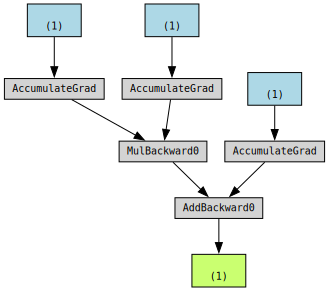

In [79]:
# Import the torch library
import torch 
from torchviz import make_dot


# Define Input variable
x = torch.randn(1, requires_grad=True)
w = torch.randn(1, requires_grad=True)
b = torch.randn(1, requires_grad=True)
 
# Define the graph structure
# Forward pass
y = w * x + b
h= 1e-7
y2 = w*(x+h)+b

# Backward pass
y.backward()
 
print( (y2-y)/h) 
print(w)
#View the outputs
print("Gradient of x:", x.grad)
print("Gradient of b:", b.grad)
print("Gradient of w:", w.grad)
 
# Update parameters
w.data -= 0.01 * w.grad.data
b.data -= 0.01 * b.grad.data
 
# Plot the computational graph
make_dot(y)

In [96]:
import torch
import torch.optim as optim

# Define Input variable
x = torch.randn(1, requires_grad=True)
w = torch.randn(1, requires_grad=True)
b = torch.randn(1, requires_grad=True)

# Define the target value
target = torch.tensor([10.0])  # Example target value

# Choose your optimizer
optimizer = optim.Adam([w, b], lr=0.01)

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    optimizer.zero_grad()  # Zero the gradients

    # Forward pass
    y = w * x + b
    
    # Compute loss (mean squared error)
    loss = (y - target).pow(2).mean()

    # Backward pass
    loss.backward()

    # Print gradients
    print(f'Epoch {epoch+1}, Gradients: w: {w.grad.item()}, b: {b.grad.item()}')

    # Update parameters
    optimizer.step()

    # Print loss and parameters
    if (epoch + 1) % 100 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}, w: {w.item()}, b: {b.item()}')

print('Training complete.')
print(f'Final parameters: w: {w.item()}, b: {b.item()}')

Epoch 1, Gradients: w: -34.30268859863281, b: -21.79442596435547
Epoch 2, Gradients: w: -34.22166442871094, b: -21.74294662475586
Epoch 3, Gradients: w: -34.14064407348633, b: -21.691471099853516
Epoch 4, Gradients: w: -34.05963897705078, b: -21.640003204345703
Epoch 5, Gradients: w: -33.9786376953125, b: -21.588539123535156
Epoch 6, Gradients: w: -33.89765548706055, b: -21.537086486816406
Epoch 7, Gradients: w: -33.81669235229492, b: -21.485645294189453
Epoch 8, Gradients: w: -33.73575210571289, b: -21.434219360351562
Epoch 9, Gradients: w: -33.65483474731445, b: -21.382808685302734
Epoch 10, Gradients: w: -33.57394790649414, b: -21.3314151763916
Epoch 11, Gradients: w: -33.49308776855469, b: -21.280040740966797
Epoch 12, Gradients: w: -33.412261962890625, b: -21.228689193725586
Epoch 13, Gradients: w: -33.331478118896484, b: -21.1773624420166
Epoch 14, Gradients: w: -33.250736236572266, b: -21.126060485839844
Epoch 15, Gradients: w: -33.1700325012207, b: -21.074785232543945
Epoch 16,